# 知识增益与上下文相关性
- 问题：随着知识增益的阈值提升，准确性增益是否也提升？
- **知识增益（Knowledge Gain, KG）**：不使用context的语义熵减去使用context的语义熵
- **知识增益阈值（Knowledge Gain Threshold, KGT）**：超过该阈值才使用context，否则不使用context

In [1]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from core.computation.uncertainty_measure import cluster_assignment_entropy

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            it = {}
            it['text'] = r['text']
            it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            responses.append(it)
    return responses

def load_greedy_response(generation_file_path):
    responses = load_responses(generation_file_path)
    assert len(responses) <= 1, f"More than one response found in {generation_file_path}."
    return responses[0] if len(responses) == 1 else None

def load_sample_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            responses.append(r['text'])
    return responses

def load_qwen_accuracy(eval_file_path):
    accuracy = []
    if os.path.exists(eval_file_path):
        res = load_pickle_file(eval_file_path)
        accuracy = res.get('qwen_scores', [])
    return accuracy[0] if len(accuracy) == 1 else None

def load_cluster_ids(clustered_file_path):
    cluster_ids = []
    if os.path.exists(clustered_file_path):
        res = load_pickle_file(clustered_file_path)
        cluster_ids = res.get('cluster_ids', [])
    return cluster_ids

# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return -1
    return cluster_assignment_entropy(cluster_ids)

# 数据
`qwen-$dataset.pkl`

```
{
	"meta": {
		"model": "qwen",
		"dataset": "$dataset"
	},
	"data": [{
		"example": {
			"id": "id1",
			"question": "q1",
			"context": "c1",
			"answers": ["a1"]
		},
		"golden": {
			"greedy_response": "gready_text",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
			"sample_responses": ["response1","response2"],
			"cluster_ids": [0,1],
			"entropy": 1.5,
			"accuracy_qwen": 1.0,
			"accuracy_gpt": 1.0,
		},
		"irrelevant": {},
		"without": {},
	}]
}

```

In [2]:
# 检查数据是否完整
def check_item(item):
    for context_type in ["golden", "irrelevant", "without"]:
        if context_type not in item:
            return False
        context = item[context_type]
        if context.get("tbg_emb", None) is None:
            return False
        if context.get("slt_emb", None) is None:
            return False
        if context.get("greedy_response", None) is None:
            return False
        if context.get("sample_responses", None) is None:
            return False
        if context.get("cluster_ids", None) is None:
            return False
        if context.get("entropy", None) is None:
            return False
        if context.get("accuracy_qwen", None) is None:
            return False
        if len(context["sample_responses"]) != len(context["cluster_ids"]):
            return False
    
    return True

def load_data(dataset_name, model_name='qwen'):
    all_data = load_pickle_file(f"output/data/{model_name}-{dataset_name}.pkl")
    data = []
    for item in all_data["data"]:
        if check_item(item):
            data.append(item)
    return data

squad: 1998


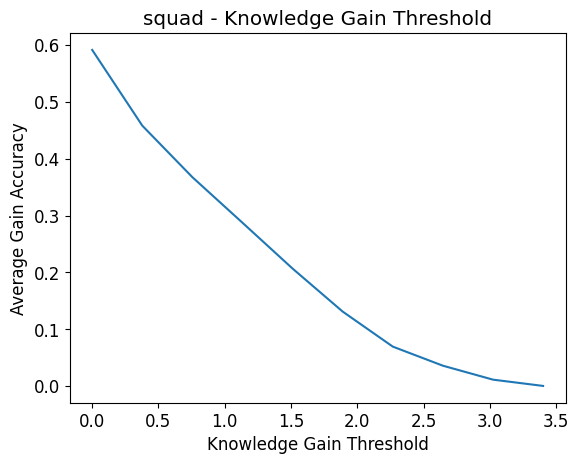

triviaqa: 1997


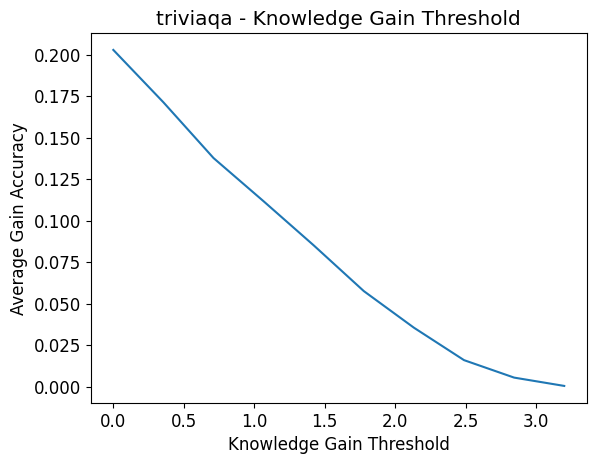

bioasq: 1997


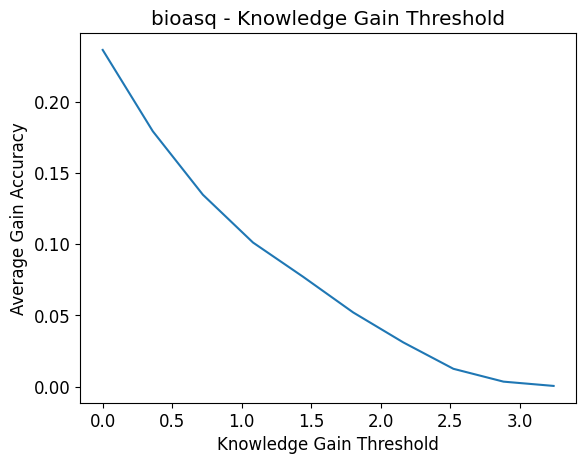

all: 5992


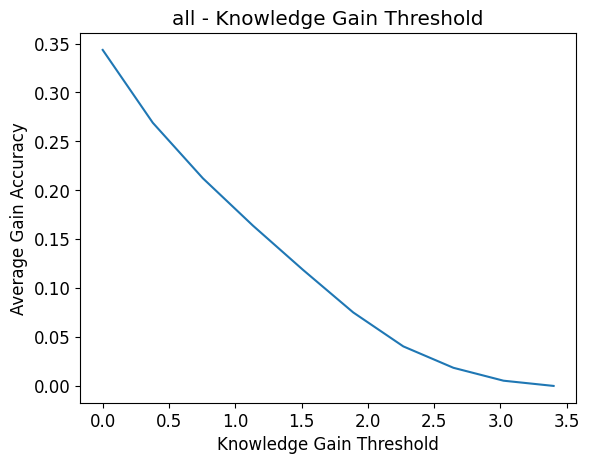

CPU times: user 7.23 s, sys: 2.15 s, total: 9.38 s
Wall time: 9.35 s


In [21]:
'''
- **知识增益（Knowledge Gain, KG）**：不使用context的语义熵减去使用context的语义熵
- **知识增益阈值（Knowledge Gain Threshold, KGT）**：超过该阈值才使用context，否则不使用context
- 绘制折线图
- 横轴是知识增益的阈值，从0开始，直到知识增益的最大值，分成10份（怎么控制步长为0.5？？）
- 纵轴是平均准确率
'''
def plot_knowledge_gain_threshold(data, dataset_name):
    kgs = []
    for item in data:
        kgs.append(item["without"]["entropy"] - item["golden"]["entropy"])
    kgs = np.array(kgs)
    # 阈值：从0开始，直到知识增益的最大值，分10份
    thresholds = np.linspace(0, kgs.max(), 10)
    # 阈值：从知识增益的最小值开始，直到知识增益的最大值，分10份
    # thresholds = np.linspace(kgs.min(), kgs.max(), 10)
    avg_accuracies = []
    for threshold in thresholds:
        accuracies = []
        for item in data:
            kg = item["without"]["entropy"] - item["golden"]["entropy"]
            dif_acc = item["golden"]["accuracy_qwen"] - item["without"]["accuracy_qwen"]
            if kg >= threshold:
                accuracies.append(dif_acc)
                # accuracies.append(item["golden"]["accuracy_qwen"])
            else:
                accuracies.append(0)
                # accuracies.append(item["without"]["accuracy_qwen"])
        avg_accuracies.append(np.mean(accuracies))
    avg_accuracies = np.array(avg_accuracies)
    plt.plot(thresholds, avg_accuracies)
    plt.xlabel("Knowledge Gain Threshold")
    plt.ylabel("Average Gain Accuracy")
    plt.title(f"{dataset_name} - Knowledge Gain Threshold")
    plt.show()

def plot_all():
    all_data = []
    for dataset in ["squad", "triviaqa", "bioasq"]:
        data = load_data(dataset)
        print(f"{dataset}: {len(data)}")
        plot_knowledge_gain_threshold(data, dataset)
        all_data.extend(data)
    print(f"all: {len(all_data)}")
    plot_knowledge_gain_threshold(all_data, "all")

%time plot_all()